In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from PIL import Image



data_dir = r"C:\Users\user\Downloads\mesh"
img_size = (224, 224)
batch_size = 64


file_paths = []
labels = []
class_names = sorted(os.listdir(data_dir))

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, img_file))
        labels.append(str(class_idx))


train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)



Found 1404 validated image filenames belonging to 6 classes.
Found 301 validated image filenames belonging to 6 classes.
Found 301 validated image filenames belonging to 6 classes.
Epoch 1/50
22/22 [==============================] - 65s 3s/step - loss: 1.9378 - accuracy: 0.7600 - val_loss: 1.9774 - val_accuracy: 0.6545 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 58s 3s/step - loss: 1.3885 - accuracy: 0.8974 - val_loss: 1.5886 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 57s 3s/step - loss: 1.2627 - accuracy: 0.9138 - val_loss: 1.2630 - val_accuracy: 0.9070 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - 58s 3s/step - loss: 1.1642 - accuracy: 0.9316 - val_loss: 1.2489 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 5/50
22/22 [==============================] - 59s 3s/step - loss: 1.0744 - accuracy: 0.9444 - val_loss: 1.0461 - val_accuracy: 0.9535 - lr: 0.0010
Epoch 6/50
22/22 [==============================] - 60

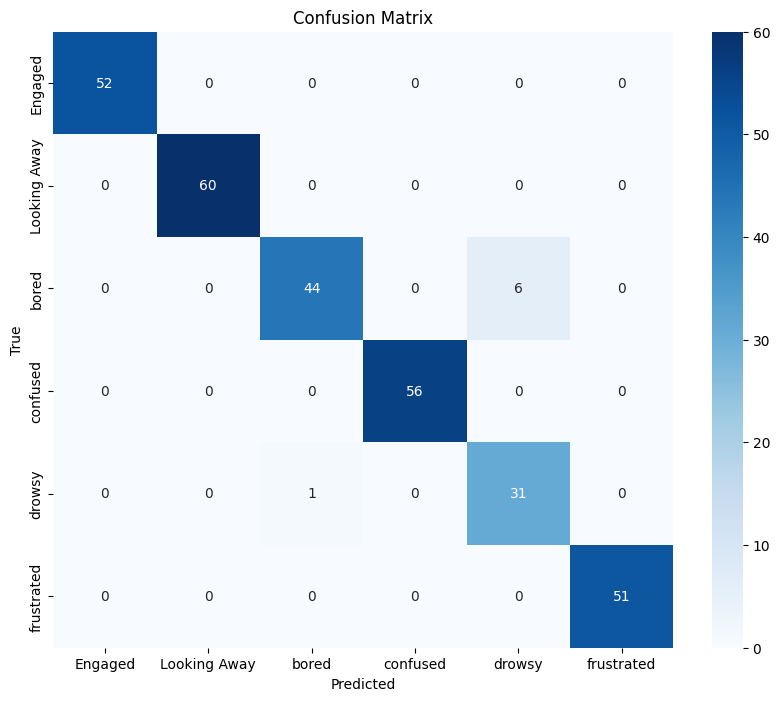

In [ ]:

from PIL import Image


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1], 
    horizontal_flip=False,       
    fill_mode='nearest'
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


def build_model():
    base_model = ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    

    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x) 
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x) 
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x) 
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(6, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model, base_model

model, resnet_base = build_model()


model.compile(optimizer=Adam(1e-3),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)


resnet_base.trainable = True


for layer in resnet_base.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    initial_epoch=len(history.epoch),
    callbacks=[early_stop, reduce_lr]
)


print("\nTest Set Evaluation:")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


test_generator.reset()
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

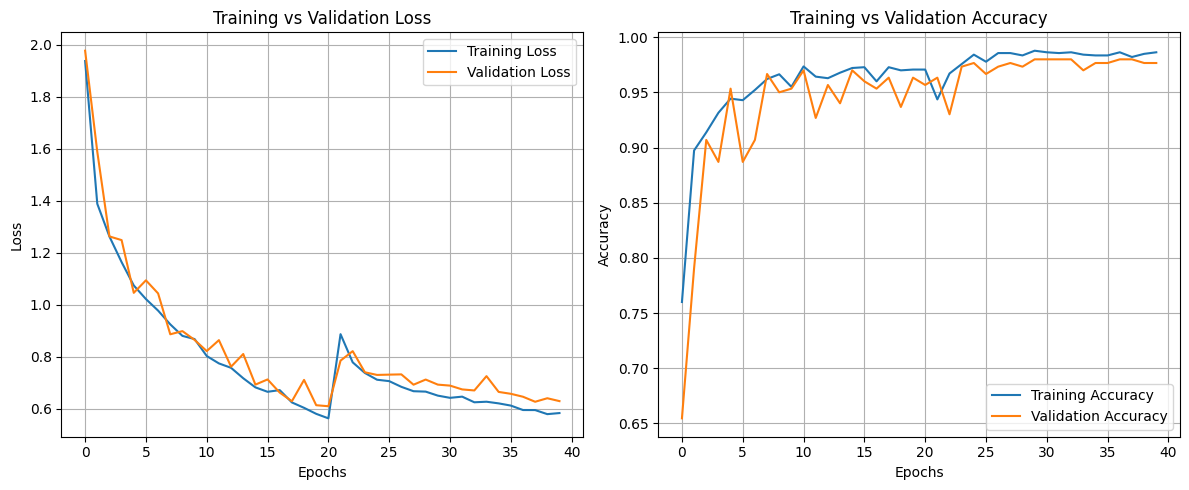

In [ ]:

combined_history = {}
for metric in history.history:
    combined_history[metric] = history.history[metric] + history_finetune.history[metric]


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(combined_history['accuracy'], label='Training Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [104]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


5/5 [==============================] - 9s 2s/step - loss: 0.7025 - accuracy: 0.9767
Test Accuracy: 0.9767


In [109]:
from tensorflow.keras.models import load_model
model.save("updated_mesh_model")



INFO:tensorflow:Assets written to: updated_mesh_model\assets


INFO:tensorflow:Assets written to: updated_mesh_model\assets


In [2]:
from tensorflow.keras.models import load_model
model = load_model('updated_mesh_model')

In [4]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

def load_and_predict(image_path, model, class_names, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size)
    img_array = img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    print("Predictions:", predictions)
    print("Predictions shape:", predictions.shape) 
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class_label} ({confidence*100:.2f}%)")
    plt.show()

    return predicted_class_label, confidence



In [9]:
import cv2
import mediapipe as mp


mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, min_detection_confidence=0.5)


def crop_face(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]
        h, w, _ = image.shape
        min_x = min([landmark.x * w for landmark in landmarks.landmark])
        min_y = min([landmark.y * h for landmark in landmarks.landmark])
        max_x = max([landmark.x * w for landmark in landmarks.landmark])
        max_y = max([landmark.y * h for landmark in landmarks.landmark])

        margin = 0.1
        x_exp = int(max(min_x - margin * w, 0))
        y_exp = int(max(min_y - margin * h, 0))
        x2_exp = int(min(max_x + margin * w, w))
        y2_exp = int(min(max_y + margin * h, h))

        cropped_face = image[y_exp:y2_exp, x_exp:x2_exp]
        return cropped_face
    return None


input_path = r"C:\Users\user\Pictures\Camera Roll\WIN_20250416_23_39_12_Pro.jpg"
output_path = r"C:\Users\user\Downloads\cropped_img122.jpg"


img = cv2.imread(input_path)


if img is not None:
    face = crop_face(img)
    if face is not None:
        face = cv2.resize(face, (224, 224))  
        cv2.imwrite(output_path, face)
        print("Face cropped and saved successfully.")
    else:
        print("No face detected.")
else:
    print("Failed to read image.")


Face cropped and saved successfully.


1/1 [==============================] - 0s 181ms/step
Predictions: [[0.02505247 0.8139223  0.06462157 0.00332497 0.03077171 0.06230703]]
Predictions shape: (1, 6)


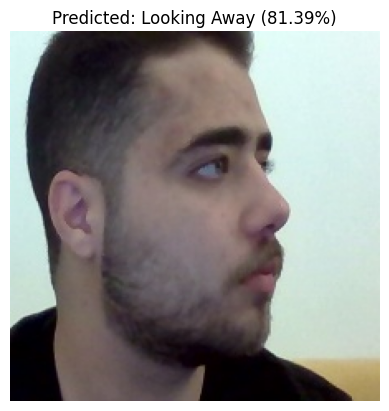

Predicted Class: Looking Away (81.39%)


In [8]:
image_path = r"C:\Users\user\Downloads\cropped_img122.jpg"
predicted_class, confidence = load_and_predict(image_path, model, class_names)
print(f"Predicted Class: {predicted_class} ({confidence*100:.2f}%)")


1/1 [==============================] - 0s 157ms/step
Predictions: [[0.02365059 0.13887508 0.48947507 0.02362659 0.12969415 0.19467856]]
Predictions shape: (1, 6)


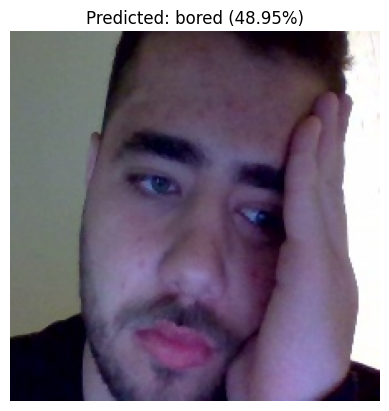

Predicted Class: bored (48.95%)


In [10]:
image_path = r"C:\Users\user\Downloads\cropped_img122.jpg"
predicted_class, confidence = load_and_predict(image_path, model, class_names)
print(f"Predicted Class: {predicted_class} ({confidence*100:.2f}%)")
